In [66]:
import tqdm
import fasttext
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cosine
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score

pd.options.mode.chained_assignment = None 


# 0. Load Data & Process model training dataset

In [60]:
data_path = 'Data\submission_and_comments_V3.csv'
save_txt_path = 'Data/comments_text.txt'

all_data = pd.read_csv(data_path, sep = ";")
data = all_data[(all_data.submission_title != "[deleted by user]") & ~(all_data.submission_title.isna())]

concat_posts = np.array(data['submission_title'])
np.savetxt(save_txt_path, concat_posts, fmt='%s', encoding="utf-8")

# 1. Build model

In [61]:
#model = fasttext.train_unsupervised("Data/comments_text.txt", model='skipgram')
model = fasttext.train_unsupervised("Data/comments_text.txt", model='cbow')

In [67]:
model.save_model("Models/cbow_model.bin")

In [4]:
embbed_data = [model[post] for post in concat_posts]

In [55]:
def K_furthest_points(list_vecs, Npoints = 3):
    data = np.matrix(list_vecs)
    c = [list(x) for x in itertools.combinations(range(len(data)), Npoints )]
    distances = []
    for i in c:    
        distances.append(np.mean(pdist(data[i,:]))) # pdist: a method of computing all pairwise Euclidean distances in a condensed way.
    ind = distances.index(max(distances)) # finding the index of the max mean distance
    rows = c[ind] # these are the points in question
    return rows

def closest3_words(vec, top_k):
    similarities =  [cosine(vec, model[w]) for w in model.words]
    top_sims = [model.words[ind] for ind in np.argsort(similarities)[: top_k]]
    top_sims_vectors = [model[w] for w in top_sims]
    topk_furtherst_points = K_furthest_points(top_sims_vectors, Npoints = 3)
    return [top_sims[point] for point in topk_furtherst_points]

closest3_words(embbed_data[0], 10)

["people's", 'posts', 'aren’t']

# 2. PCA

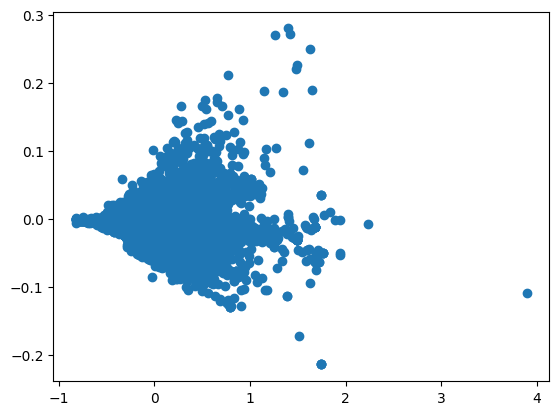

In [5]:
pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(embbed_data)
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
plt.scatter(x0, x1)

# 3. UMAP

In [40]:
umap_reducer = umap.UMAP(metric = "cosine", verbose = True, n_neighbors = 200, min_dist = 0)
umap_embedding = umap_reducer.fit_transform(embbed_data)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_neighbors=200, verbose=True)
Sun May 21 00:23:29 2023 Construct fuzzy simplicial set
Sun May 21 00:23:29 2023 Finding Nearest Neighbors
Sun May 21 00:23:29 2023 Building RP forest with 12 trees
Sun May 21 00:23:29 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun May 21 00:23:56 2023 Finished Nearest Neighbor Search
Sun May 21 00:23:58 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:15]

Sun May 21 00:24:17 2023 Finished embedding


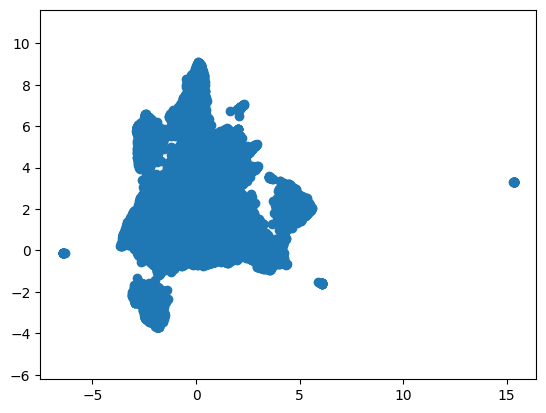

In [41]:
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')

# 4. Kmeans Elbow ?

In [44]:
Sum_of_squared_distances = []
K = tqdm.trange(1,1001, 100)
for num_clusters in K:
    kmeans = KMeans(n_clusters=num_clusters, n_init = "auto", init = "k-means++")
    kmeans.fit(embbed_data)
    Sum_of_squared_distances.append(kmeans.inertia_)

100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


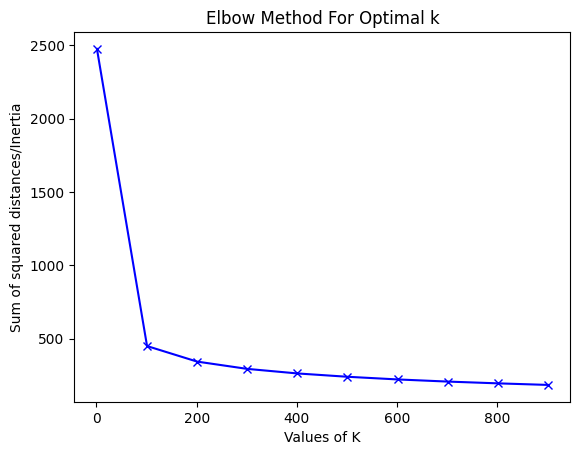

In [45]:
plt.plot(range(1,1001, 100),Sum_of_squared_distances,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

In [46]:
Sum_of_squared_distances = []
K = tqdm.trange(1,201, 1)
for num_clusters in K:
    kmeans = KMeans(n_clusters=num_clusters, n_init = "auto", init = "k-means++")
    kmeans.fit(embbed_data)
    Sum_of_squared_distances.append(kmeans.inertia_)

100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


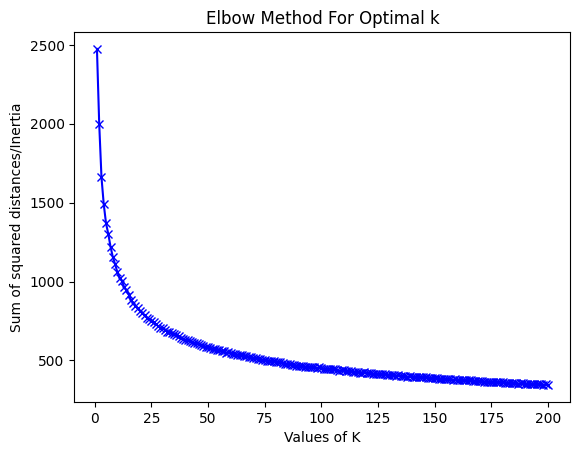

In [50]:
plt.plot(range(1,201, 1),Sum_of_squared_distances,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

# 5. Save Kmeans clusters for $k\in [50,100,150,200]$

In [56]:
submission_titles = data[['submission_title']]
k_range = [50,100,150,200, 1000]
for kk in tqdm.tqdm(k_range):
    clustering_model = KMeans(n_clusters=kk, random_state=42, init = "k-means++", n_init = "auto")
    clustering_model.fit(embbed_data)
    submission_titles[f'KMeans_k={kk}'] = clustering_model.labels_

    top_words_list = []

    for k_see_words in np.unique(clustering_model.labels_):
        cluster_sentences = submission_titles[submission_titles[f'KMeans_k={kk}'] == k_see_words]
        mean_model = np.mean([model[cluster_sentences.iloc[i].values[0]] for i in range(len(cluster_sentences))], axis = 0)
        top10_words = closest3_words(mean_model, 10)
        top_words_list.append(top10_words)

    cluster2top_words = dict(zip(np.unique(clustering_model.labels_), top_words_list))
    submission_titles[f'Top5_k={kk}'] = submission_titles[f'KMeans_k={kk}'].apply(lambda x: cluster2top_words[x])

100%|██████████| 5/5 [04:25<00:00, 53.12s/it]


In [57]:
submission_titles.to_csv('Data/SkipGram_KMeans_TitlesClusters_k=50-100-150-200-1000.csv')
submission_titles

,submission_title,FastText_KMeans_k=50_AllDims,FastText_KMeans_k=100_AllDims,FastText_KMeans_k=150_AllDims,FastText_KMeans_k=200_AllDims,FastText_KMeans_k=1000_AllDims
1,Another reason I need to get off social media-...,3,50,16,181,363
2,Having a flip phone changed my life (for good),5,82,108,108,604
4,The ultimate nosurf solution by using timer so...,24,15,43,43,916
5,I'm thankful for ads,31,52,53,53,820
6,"On Silence (and creativity), a short essay by ...",42,5,68,68,38
...,...,...,...,...,...,...
22138,Joining the no surf september challenge,39,64,24,145,559
22139,1st report for my September Challenge,49,64,145,145,350
22140,Suggest software to make the nosurf experience...,8,26,137,137,175
22141,No Surf September,41,64,24,145,514


: 